# EE4375-2022: Linear and Non-Linear (including saturation) Coil-Core-Air configuration 

Here we simulate the magnetic field of a coil around a ferromagnetic core. Give dimensions of coil and core. (include a figure here). 

Need to extend to: 
1. eddy-current modeling at various frequencies (by adding mass matrix in linear system solve); 
2. second-order elements showing that fewer degrees of freedom are required; how to implement parametric function that switch between first and second methods; 
3. adding electrical circuit equation by extending matrix with an additional row and collumn; 
4. transient modeling using hand-coded time-loop (can be done by various methods);
5. transient modeling using DifferentialEquations.jl  (can be done by various methods); 
6. multi-harmonic modeling. Form larger system. Solve using backslash.  

## Import Packages

In [10]:
using LinearAlgebra
using StructArrays
using StaticArrays
using Plots
using LaTeXStrings
using SparseArrays
using BoundaryValueDiffEq
using BenchmarkTools 

## Section 1:/ Introduction  
More text here.

## Section 2:/ Shooting Method 

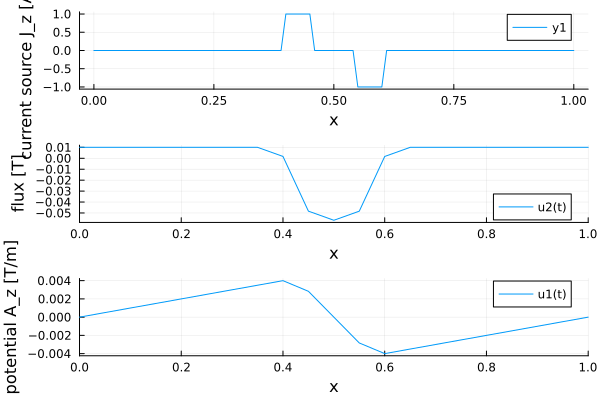

In [19]:
# define spatial range 
xspan = (0.0, 1)

# define the source function f(x)
function fsource(x)
    return 1*((x>=.4)*(x<=.45) - (x>=.55)*(x<=.6))
end

# define diffusion equation 
function diffusion!(du, u, p, x)
    # u[1]: concentration 
    # u[2]: fluc 
    # d/dx(concentration)  = flux 
    du[1] = u[2]
    # d/dx(flux)  = sourceFct
    du[2] = - fsource(x)
end

# define boundary conditions 
function boundaries!(residual, u, p, x)
    # residual boundary condition in the left end-point 
    residual[1] = u[1][1] 
    # residual boundary condition in the left end-point
    residual[2] = u[end][1]
end 

# set the boundary value problem to solve  
bvp1 = BVProblem(diffusion!, boundaries!, [1., 1.], xspan)

# set the boundary value problem  
sol = solve(bvp1, GeneralMIRK4(), dt = 0.05)

# plot the computed solution
xvec = Vector(xspan[1]:(xspan[2]-xspan[1])/100:xspan[2])
fvec = fsource.(xvec)
p1 = plot(xvec,fvec)
xlabel!("x") 
ylabel!("current source J_z [A/m^2]")

p2 = plot(sol,idxs=2)
xlabel!("x")
ylabel!("flux [T]")

p3 = plot(sol,idxs=1)
xlabel!("x") 
ylabel!("potential A_z [T/m]")

plot(p1,p2,p3,layout=(3,1))

## Section 3:/ FEM Computations 

In [159]:
fsource(x) = 10*((x>=.4)*(x<=.45) - (x>=.55)*(x<=.6))
fsource(x) = 1*((x>=.4)*(x<=.45) - (x>=.55)*(x<=.6))
flinearmur(x) = 1+1000*(x>=.45)*(x<=.55)
fnonlinearmur(x,flux2) = 1+(Derivative(1) * hnormSpline)(flux2)*(x>=.45)*(x<=.55)

fnonlinearmur (generic function with 1 method)

### Section 1.3:/ Coil - Air (no Core) configuration 
Observe that the potential (squared flux) is proportional to the amplitude of the current application (squared). 

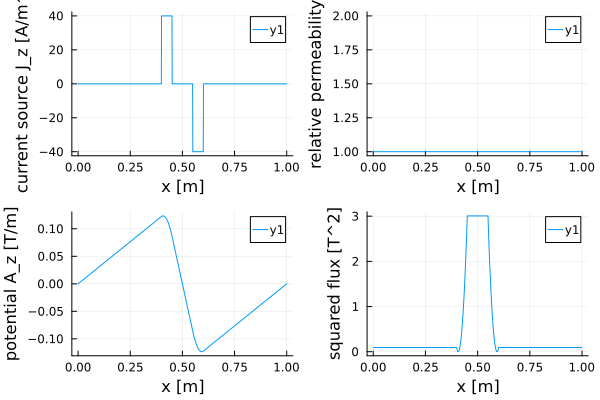

In [23]:
#..set current source and relative permeability of the core 
fsource(x) = 40*((x>=.4)*(x<=.45) - (x>=.55)*(x<=.6))
flinearmur(x) = 1

#..Generate mesh 
N = 1000
mesh,x = generateMesh1D(N)

#..Generate linear system 
A = generateStiffMatrix1D(mesh)
f = generateVector1D(mesh)
u = A \ f 
flux2 = generateFlux1D(u,mesh)

#..Post processing 
xmid = (x[1:end-1]+x[2:end])/2 
p1 = plot(x,N*f)
xlabel!("x [m]") 
ylabel!("current source J_z [A/m^2]")
p2 = plot(xmid,flinearmur.(xmid))
xlabel!("x [m]")
ylabel!("relative permeability")
p3 = plot(x,u)
xlabel!("x [m]")
ylabel!("potential A_z [T/m]")
p4 = plot(xmid,flux2)
xlabel!("x [m]")
ylabel!("squared flux [T^2]")
plot(p1,p2,p3,p4,layout=(2,2))

### Section 2.3:/ Coil - Air - Linear Core (no saturation) Configuration 
Observe how the flux increases with the relative permeability of the core (as expected). 

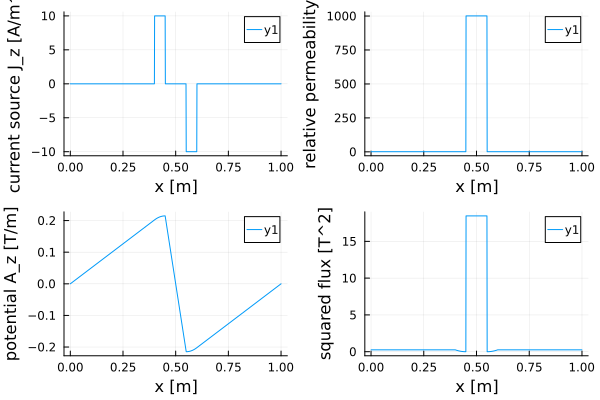

In [24]:
#..set current source and relative permeability of the core 
fsource(x) = 10*((x>=.4)*(x<=.45) - (x>=.55)*(x<=.6))
flinearmur(x) = 1+1000*(x>=.45)*(x<=.55)

#..Generate mesh 
N = 1000
mesh,x = generateMesh1D(N)

#..Generate linear system 
A = generateStiffMatrix1D(mesh)
f = generateVector1D(mesh)
u = A \ f 
flux2 = generateFlux1D(u,mesh)

#..Post processing 
xmid = (x[1:end-1]+x[2:end])/2 
p1 = plot(x,N*f)
xlabel!("x [m]") 
ylabel!("current source J_z [A/m^2]")
p2 = plot(xmid,flinearmur.(xmid))
xlabel!("x [m]")
ylabel!("relative permeability")
p3 = plot(x,u)
xlabel!("x [m]")
ylabel!("potential A_z [T/m]")
p4 = plot(xmid,flux2)
xlabel!("x [m]")
ylabel!("squared flux [T^2]")
plot(p1,p2,p3,p4,layout=(2,2))

### Section 3.3:/ Coil - Air - Non-Linear Core (including saturation) Configuration
Observe how in the presence of saturation the flux remains limited.

0.25890018045921176

0.018123012632145167

0.0012686108842501099

8.880276189752427e-5

6.216193332826695e-6

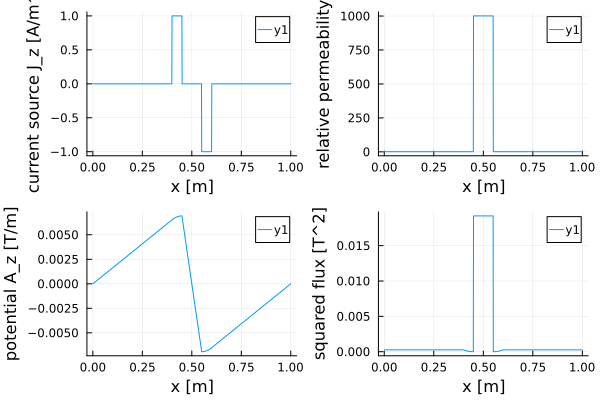

In [25]:
#..set current source and relative permeability of the core
fsource(x) = 1*((x>=.4)*(x<=.45) - (x>=.55)*(x<=.6))
flinearmur(x) = 1+1000*(x>=.45)*(x<=.55)
fnonlinearmur(x,flux2) = 1+(Derivative(1) * hnormSpline)(flux2)*(x>=.45)*(x<=.55)

#..Generate mesh 
N = 1000
mesh,x = generateMesh1D(N)

#..Generate linear system 
A = generateMatrix1D(mesh)
f = generateVector1D(mesh)
u = A \ f 
flux2 = generateFlux1D(u,mesh)

#..Solve non-linear system 
maxit=5
for k=1:maxit
  A = generateStiffMatrixNonlin1D(u, mesh)
  uold = u
  ucorr = A \ f 
  u = .07*u+0.3*ucorr
  display(norm(u-uold))
  flux2 = generateFlux1D(u,mesh) 
end 

#..Post processing 
xmid = (x[1:end-1]+x[2:end])/2 
p1 = plot(x,N*f)
xlabel!("x [m]") 
ylabel!("current source J_z [A/m^2]")
p2 = plot(xmid,flinearmur.(xmid))
xlabel!("x [m]")
ylabel!("relative permeability")
p3 = plot(x,u)
xlabel!("x [m]")
ylabel!("potential A_z [T/m]")
p4 = plot(xmid,flux2)
xlabel!("x [m]")
ylabel!("squared flux [T^2]")
plot(p1,p2,p3,p4,layout=(2,2))

### Section 4.3:/ Coil - Air - Conductive Core (excluding saturation) Configuration

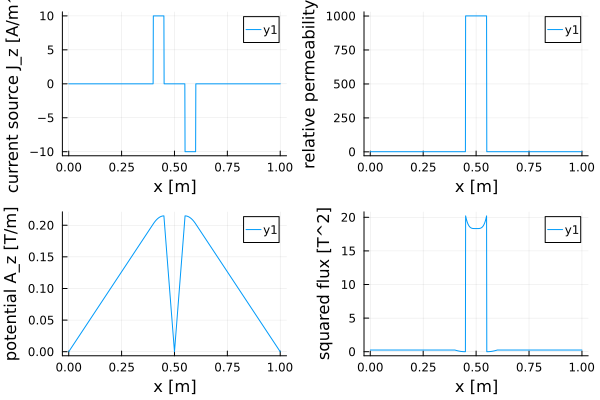

In [37]:
#..set current source and relative permeability of the core 
fsource(x) = 10*((x>=.4)*(x<=.45) - (x>=.55)*(x<=.6))
flinearmur(x) = 1+1000*(x>=.45)*(x<=.55)
fsigma(x) = 1+1000*(x>=.45)*(x<=.55) 
fsigma(x) = 1+50*(x>=.45)*(x<=.55)

#..Generate mesh 
N = 1000
mesh,x = generateMesh1D(N)

#..Generate linear system 
A = generateStiffMatrix1D(mesh)
M = generateMassMatrix1D(mesh)
f = generateVector1D(mesh)
u = (2*π*0.001*1im*M + A) \ f 
flux2 = generateFlux1D(u,mesh)

#..Post processing 
xmid = (x[1:end-1]+x[2:end])/2 
p1 = plot(x,N*f)
xlabel!("x [m]") 
ylabel!("current source J_z [A/m^2]")
p2 = plot(xmid,flinearmur.(xmid))
xlabel!("x [m]")
ylabel!("relative permeability")
p3 = plot(x,abs.(u))
xlabel!("x [m]")
ylabel!("potential A_z [T/m]")
p4 = plot(xmid,abs.(flux2))
xlabel!("x [m]")
ylabel!("squared flux [T^2]")
plot(p1,p2,p3,p4,layout=(2,2))

## Section 4:/ Libraries 

### Section 1.4:/ FEM Functions 

In [31]:
# struct to hold single element
struct Element
  p1::Float64
  p2::Float64
  e1::Int64
  e2::Int64
end 

function generateMesh1D(N)
  h::Float64 = 1/N
  x = Vector(0:h:1) 
  mesh = StructArray{Element}((x[1:end-1], x[2:end], Vector(1:N), Vector(2:N+1)))
  return mesh, x 
end 

function generateStiffMatrix1D(mesh) 
    
    #..Retrieve number of elements 
    N = length(mesh); 
    if (Bool(0)) print(" [generateStiffMatrix1D]:: input N = ", N, "\n") end

    #..Initialize local and global matrix  
    I = zeros(Int64,4*N)
    J = zeros(Int64,4*N)
    Avalues = zeros(Float64,4*N)
    Aloc = zeros(Float64,2,2)

    #..Perform loop over elements and assemble global matrix and vector 
    i = 1
    @inbounds for elem in mesh 
      xl = elem.p1
      xr = elem.p2
      j  = elem.e1
      k  = elem.e2
      murvalue = flinearmur((xl+xr)/2)   
      Aloc = (1/murvalue)*1/(xr-xl)*[1, -1, -1, 1];        
      I[4*(i-1)+1:4*i] = [j, k, j, k]
      J[4*(i-1)+1:4*i] = [j, j, k, k]
      Avalues[4*(i-1)+1:4*i] = Aloc         
      i+=1
    end

    A = sparse(I,J,Avalues)

    #..handle the boundary conditions in the matrix 
    A[1,1] = 1;     A[1,2] = 0;        
    A[end,end-1]=0; A[end,end] = 1;   
    
    return A 
    
end

function generateMassMatrix1D(mesh) 
    
    #..Retrieve number of elements 
    N = length(mesh); 
    if (Bool(0)) print(" [generateMassMatrix1D]:: input N = ", N, "\n") end

    #..Initialize local and global matrix  
    I = zeros(Int64,2*N)
    J = zeros(Int64,2*N)
    Mvalues = zeros(Float64,2*N)
    Mloc = zeros(Float64,2,1)

    #..Perform loop over elements and assemble global matrix and vector 
    i = 1
    @inbounds for elem in mesh 
      xl = elem.p1
      xr = elem.p2
      j  = elem.e1
      k  = elem.e2
      sigmavalue = fsigma((xl+xr)/2)   
      Mloc = sigmavalue*(xr-xl)/2*[1, 1]; 
      Iloc = 2*(i-1)+1:2*i
      I[Iloc] = [j, k]
      J[Iloc] = [j, k]
      Mvalues[Iloc] = Mloc         
      i+=1
    end

    M = sparse(I,J,Mvalues)
    
    return M 
    
end

function generateVector1D(mesh) 
    
    #..Retrieve number of elements 
    N = length(mesh); 
    if (Bool(0)) print(" [generateVector1D]:: input N = ", N, "\n") end

    #..Initialize local and global matrix  
    I = zeros(Int64,4*N)
    f = zeros(Float64,N+1)
    floc = zeros(Float64,2,1)
    
    #..Perform loop over elements and assemble global matrix and vector 
    @inbounds for elem in mesh 
      xl = elem.p1
      xr = elem.p2
      j  = elem.e1
      k  = elem.e2
      floc = .5*(xr-xl)*[fsource(xl); fsource(xr)];
      f[[j;k]] += floc 
    end

    #..handle the boundary conditions in the matrix 
    f[1]   = 0; f[end] = 0;    
    
    return f 
    
end

function generateFlux1D(u,mesh) 
    
    #..Retrieve number of elements 
    N = length(mesh); 
    if (Bool(0)) print(" [generateFlux1D]:: input N = ", N, "\n") end

    #..Initialize local and global matrix  
    flux2 = zeros(Complex,N)
    
    #..Perform loop over elements and assemble global matrix and vector 
    i = 1
    @inbounds for elem in mesh 
      xl = elem.p1
      xr = elem.p2
      j  = elem.e1
      k  = elem.e2
      flux2[i] = ((u[k]-u[j])/(xr-xl))^2;
      i += 1;
    end
    
    return flux2 
    
end

function generateStiffMatrixNonlin1D(u,mesh) 
    
    #..Retrieve number of elements 
    N = length(mesh); 
    if (Bool(0)) print(" [generateStiffMatrixNonlin1D]:: input N = ", N, "\n") end

    #..Initialize local and global matrix  
    I = zeros(Int64,4*N)
    J = zeros(Int64,4*N)
    Avalues = zeros(Float64,4*N)
    Aloc = zeros(Float64,2,2)
    
    By2 = generateFlux1D(u,mesh)

    #..Perform loop over elements and assemble global matrix and vector 
    i = 1
    @inbounds for elem in mesh 
      xl = elem.p1
      xr = elem.p2
      j  = elem.e1
      k  = elem.e2
      murvalue = fnonlinearmur((xl+xr)/2,By2[i]) 
      Aloc = (1/murvalue)*(1/(xr-xl))*[1, -1, -1, 1];        
      I[4*(i-1)+1:4*i] = [j, k, j, k]
      J[4*(i-1)+1:4*i] = [j, j, k, k]
      Avalues[4*(i-1)+1:4*i] = Aloc         
      i+=1
    end

    A = sparse(I,J,Avalues)

    #..handle the boundary conditions in the matrix 
    A[1,1] = 1;     A[1,2] = 0;        
    A[end,end-1]=0; A[end,end] = 1;   
    
    return A 
    
end

generateStiffMatrixNonlin1D (generic function with 1 method)

### Section 2.4:/ Saturation Data 

In [3]:
using BSplineKit
using Plots 

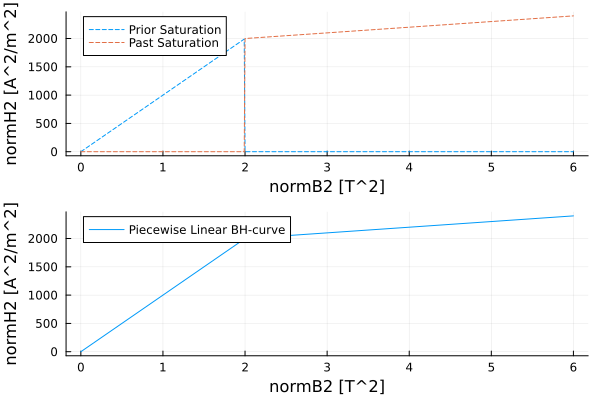

In [4]:
# three parameters that define piecewise linear B-H curve 
murLinear = 1000;
murSaturated    = 100; 
bnorm2Saturared = 2

# piecewise linear functions 
hnorm2OffSet            = (murLinear-murSaturated)*bnorm2Saturared;
murLinearFct(bnorm2)    = murLinear*bnorm2*(bnorm2<bnorm2Saturared) 
murSaturatedFct(bnorm2) = (murSaturated*bnorm2+hnorm2OffSet)*(bnorm2>=bnorm2Saturared)
mur(bnorm2)             = murLinearFct(bnorm2) + murSaturatedFct(bnorm2)

bnorm2          = Vector(0:0.01:6)
hnorm2Linear    = murLinearFct.(bnorm2);
hnorm2Saturated = murSaturatedFct.(bnorm2);
hnorm2 = mur.(bnorm2)

p1 = plot(bnorm2, hnorm2Linear,ls=:dash,label="Prior Saturation")
p1 = plot!(bnorm2, hnorm2Saturated,ls=:dash,label="Past Saturation")
xlabel!("normB2 [T^2]") 
ylabel!("normH2 [A^2/m^2]")
p2 = plot(bnorm2, hnorm2,label="Piecewise Linear BH-curve")
xlabel!("normB2 [T^2]") 
ylabel!("normH2 [A^2/m^2]")
plot(p1,p2,layout=(2,1))

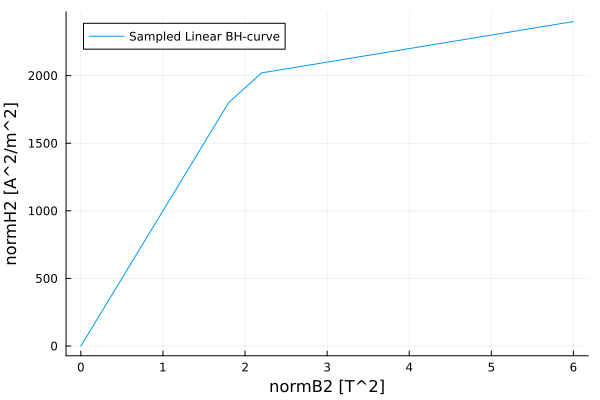

In [5]:
bnorm2LinearSampled    = Vector(0:.1:bnorm2Saturared-0.2)
bnorm2SaturatedSampled = Vector(bnorm2Saturared+0.2:.1:6)
hnorm2LinearSampled    = murLinearFct.(bnorm2LinearSampled)
hnorm2SaturatedSampled = murSaturatedFct.(bnorm2SaturatedSampled)
bnorm2Sampled          = [bnorm2LinearSampled; bnorm2SaturatedSampled]
hnorm2Sampled          = [hnorm2LinearSampled; hnorm2SaturatedSampled]
plot(bnorm2Sampled, hnorm2Sampled,label="Sampled Linear BH-curve")
xlabel!("normB2 [T^2]") 
ylabel!("normH2 [A^2/m^2]")

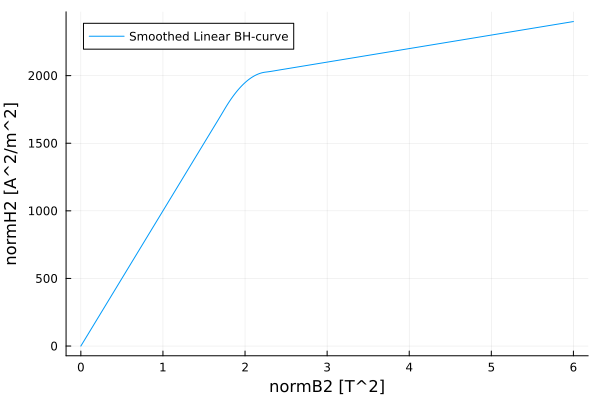

In [6]:
hnormSpline     = interpolate(bnorm2Sampled, hnorm2Sampled, BSplineOrder(3));
bnorm2          = Vector(0:0.01:6)
hnormSplineEval = (Derivative(0) * hnormSpline).(bnorm2)
plot(bnorm2,hnormSplineEval,label="Smoothed Linear BH-curve")
xlabel!("normB2 [T^2]") 
ylabel!("normH2 [A^2/m^2]")

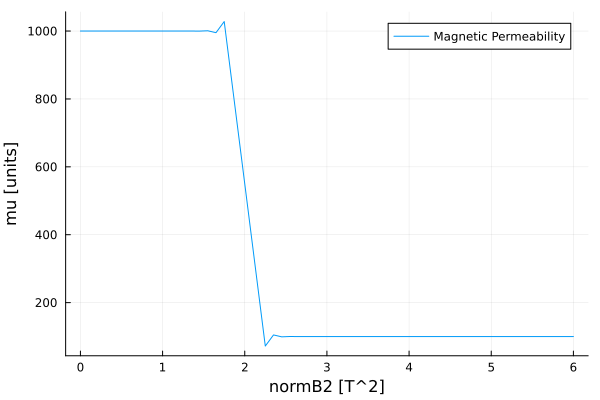

In [7]:
murSpline = (Derivative(1) * hnormSpline).(bnorm2)
plot(bnorm2,murSpline,label="Magnetic Permeability")
xlabel!("normB2 [T^2]") 
ylabel!("mu [units]")

In [8]:
(Derivative(1) * hnormSpline)(2)

549.9999999999991